# Sentiment analysis on women´s e-commerce clothing review


With the rapid growth of e-commerce, online reviews have become an essential source of information for both businesses and consumers. In the fashion industry, customer feedback not only reflects product quality but also reveals satisfaction, preferences, and expectations. This project aims to explore sentiment analysis of women’s clothing reviews, mainly collected from Amazon, in order to better understand consumer opinions and uncover trends in online shopping experiences.

In [171]:
pip install kaggle



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [90]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [92]:
!mkdir -p ~/.kaggle

In [94]:
!kaggle datasets list -s reviews

ref                                           title                                      size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------  -----------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
zynicide/wine-reviews                         Wine Reviews                           53336293  2017-11-27 17:08:04.700000         335310       3775  0.7941176        
kritanjalijain/amazon-reviews                 Amazon reviews                       1389222210  2021-05-15 09:45:40.597000          33999        220  1.0              
arushchillar/disneyland-reviews               Disneyland Reviews                     11639652  2021-01-19 07:00:59.937000          13911        159  1.0              
jvanelteren/boardgamegeek-reviews             BoardGameGeek Reviews                1725880092  2025-02-01 14:35:33.237000           6022        142  1.0             

In [96]:
path = "~/.kaggle/kaggle.json"
print(path)



~/.kaggle/kaggle.json


In [98]:
!kaggle datasets download -d nicapotato/womens-ecommerce-clothing-reviews



Dataset URL: https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews
License(s): CC0-1.0
womens-ecommerce-clothing-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [101]:
import zipfile

with zipfile.ZipFile("womens-ecommerce-clothing-reviews.zip", "r") as zip_ref:
    zip_ref.extractall("womens_reviews")


In [103]:
import os

print(os.listdir("womens_reviews"))

['Womens Clothing E-Commerce Reviews.csv']


In [105]:
df = pd.read_csv("womens_reviews/Womens Clothing E-Commerce Reviews.csv")
print(df.shape)
print(df.columns)

# Limpieza inicial
df = df.dropna(subset=["Review Text", "Rating"])

(23486, 11)
Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')


In [107]:
# 3. Crear variable de sentimiento
def label_sentiment(r):
    if r >= 4:
        return "positivo"
    elif r == 3:
        return "neutro"
    else:
        return "negativo"

df["sentiment"] = df["Rating"].apply(label_sentiment)
print(df["sentiment"].value_counts())

sentiment
positivo    17448
neutro       2823
negativo     2370
Name: count, dtype: int64


In [109]:
# 4. Preprocesamiento de texto
def clean_text(txt):
    txt = txt.lower()
    txt = re.sub(f"[{string.punctuation}]", "", txt)
    txt = re.sub(r"\s+", " ", txt).strip()
    return txt

df["clean_review"] = df["Review Text"].apply(clean_text)

# 5. TF-IDF
X = df["clean_review"]
y = df["sentiment"]
tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
X_tfidf = tfidf.fit_transform(X)

In [111]:
# 6. Train-test split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)



## Random Forest

In [113]:

# 7.Random Forest Model
model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

              precision    recall  f1-score   support

    negativo       0.67      0.16      0.25       474
      neutro       0.52      0.02      0.04       565
    positivo       0.79      1.00      0.88      3490

    accuracy                           0.79      4529
   macro avg       0.66      0.39      0.39      4529
weighted avg       0.75      0.79      0.71      4529



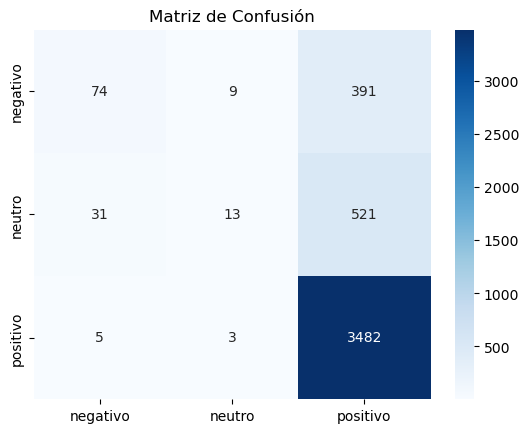

In [114]:
#8. Evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Matriz de Confusión")
plt.show()

/var/folders/m8/m959tpc548j6_wtfd19v0m600000gn/T/ipykernel_83349/3193229868.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="sentiment", palette="viridis")


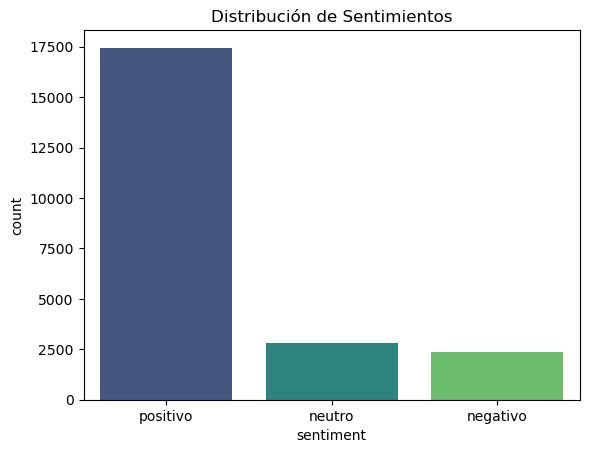

In [115]:
sns.countplot(data=df, x="sentiment", palette="viridis")
plt.title("Distribución de Sentimientos")
plt.show()

## Logistic Regression

In [119]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

              precision    recall  f1-score   support

    negativo       0.62      0.42      0.50       474
      neutro       0.41      0.20      0.27       565
    positivo       0.86      0.97      0.91      3490

    accuracy                           0.82      4529
   macro avg       0.63      0.53      0.56      4529
weighted avg       0.78      0.82      0.79      4529



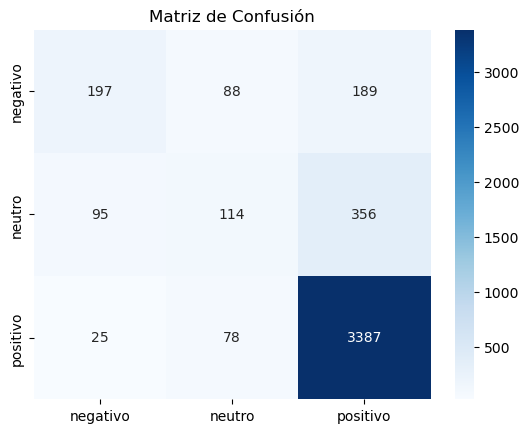

In [121]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

# Reporte de métricas
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=["negativo", "neutro", "positivo"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["negativo", "neutro", "positivo"],
            yticklabels=["negativo", "neutro", "positivo"])
plt.title("Matriz de Confusión")
plt.show()

## XGBoost

In [137]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Codificamos las etiquetas
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train_enc)

print("Antes de SMOTE:", y_train_enc.shape)
print("Después de SMOTE:", y_train_bal.shape)

# Entrenamos con las etiquetas numéricas


xgb_model = XGBClassifier(
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)


xgb_model.fit(X_train_bal, y_train_bal)

# Predicciones
y_pred_xgb = xgb_model.predict(X_test)

# Decodificamos las predicciones a texto
y_pred_labels = le.inverse_transform(y_pred_xgb)

Antes de SMOTE: (18112,)
Después de SMOTE: (41874,)


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:07:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

    negativo       0.55      0.44      0.49       474
      neutro       0.35      0.17      0.23       565
    positivo       0.86      0.95      0.90      3490

    accuracy                           0.80      4529
   macro avg       0.59      0.52      0.54      4529
weighted avg       0.76      0.80      0.77      4529



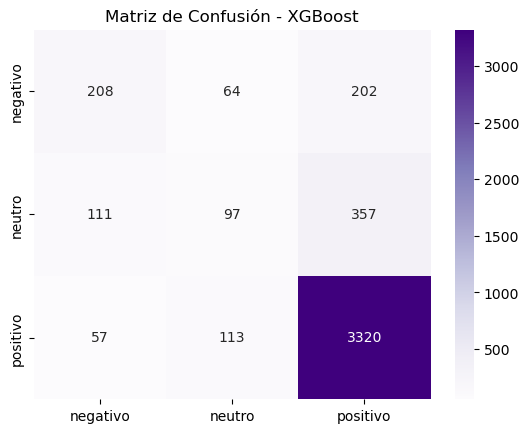

In [138]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Reporte
print(classification_report(y_test, y_pred_labels))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_labels, labels=le.classes_)
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title("Matriz de Confusión - XGBoost")
plt.show()

   Unnamed: 0  Clothing ID  Age                    Title  \
0           0          767   33                      NaN   
1           1         1080   34                      NaN   
2           2         1077   60  Some major design flaws   
3           3         1049   50         My favorite buy!   
4           4          847   47         Flattering shirt   

                                         Review Text  Rating  Recommended IND  \
0  Absolutely wonderful - silky and sexy and comf...       4                1   
1  Love this dress!  it's sooo pretty.  i happene...       5                1   
2  I had such high hopes for this dress and reall...       3                0   
3  I love, love, love this jumpsuit. it's fun, fl...       5                1   
4  This shirt is very flattering to all due to th...       5                1   

   Positive Feedback Count   Division Name Department Name Class Name  \
0                        0       Initmates        Intimate  Intimates   
1     

/var/folders/m8/m959tpc548j6_wtfd19v0m600000gn/T/ipykernel_83349/706573223.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Rating", data=df, palette="viridis")


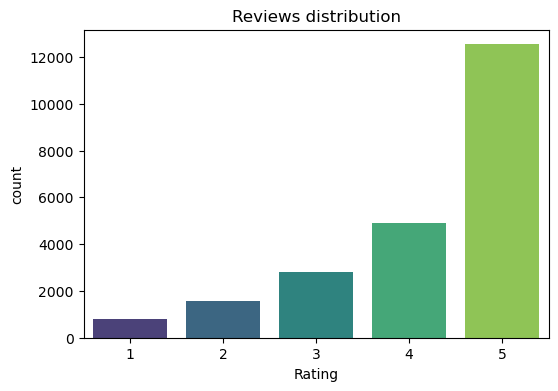

Average review lenght: 60.19667859193498

--- Example of a NEGATIVE review ---
I love tracy reese dresses, but this one is not for the very petite. i am just under 5 feet tall and usually wear a 0p in this brand. this dress was very pretty out of the package but its a lot of dress. the skirt is long and very full so it overwhelmed my small frame. not a stranger to alterations, shortening and narrowing the skirt would take away from the embellishment of the garment. i love the color and the idea of the style but it just did not work on me. i returned this dress.

--- Example of a NEUTRAL review---
I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Ver las primeras filas
print(df.head())

# 2. Distribución de calificaciones (Rating)
plt.figure(figsize=(6,4))
sns.countplot(x="Rating", data=df, palette="viridis")
plt.title("Reviews distribution")
plt.show()

# 3. Promedio de longitud de reseñas
df["review_length"] = df["Review Text"].apply(lambda x: len(str(x).split()))
print("Average review lenght:", df["review_length"].mean())

# 4. Ejemplos de reseñas positivas, neutras y negativas
print("\n--- Example of a NEGATIVE review ---")
print(df[df["Rating"] <= 2]["Review Text"].iloc[0])

print("\n--- Example of a NEUTRAL review---")
print(df[df["Rating"] == 3]["Review Text"].iloc[0])

print("\n--- Example of a POSITIVE review ---")
print(df[df["Rating"] >= 4]["Review Text"].iloc[0])

### Conclusion

Four models were evaluated to classify customer sentiment in women’s clothing reviews: Random Forest, Logistic Regression, XGBoost, and XGBoost with SMOTE.
Random Forest not performed as well as we expected, the desbalance of classes was very stronger so the accuracy for neutrals and ngatives wasn´t good enough
Logistic Regression achieved the strongest overall performance, particularly in identifying minority classes, making it the most effective model for this dataset.
XGBoost (without balancing) performed very well in recognizing positive reviews but struggled with negative and neutral ones due to class imbalance.
XGBoost with SMOTE improved recall and F1-score for negative reviews (from 0.42 to 0.49), but still underperformed compared to Logistic Regression.
These results highlight that more complex models such as XGBoost are not always superior; simpler models like Logistic Regression can outperform them when dealing with high-dimensional, sparse data such as TF-IDF text features. Furthermore, applying resampling techniques like SMOTE can partially mitigate class imbalance, but may not fully bridge the gap in minority class detection.